In [3]:
!pip install torchvision segmentation-models-pytorch
!pip install gdown


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
print("Images:", os.listdir('/content/drive/MyDrive/imageData'))
print("Masks:", os.listdir('/content/drive/MyDrive/maskData'))


Images: ['TrainImage_Varanasi_2024.tif', 'TrainImage_Patna_2024.tif', 'TrainImage_Prayagraj_2024.tif', 'TrainImage_Varanasi_2014.tif', 'TrainImage_Patna_2014.tif', 'TrainImage_Prayagraj_2014.tif']
Masks: ['TrainMask_Varanasi_2024.tif', 'TrainMask_Prayagraj_2024.tif', 'TrainMask_Patna_2024.tif', 'TrainMask_Varanasi_2014.tif', 'TrainMask_Patna_2014.tif', 'TrainMask_Prayagraj_2014.tif']


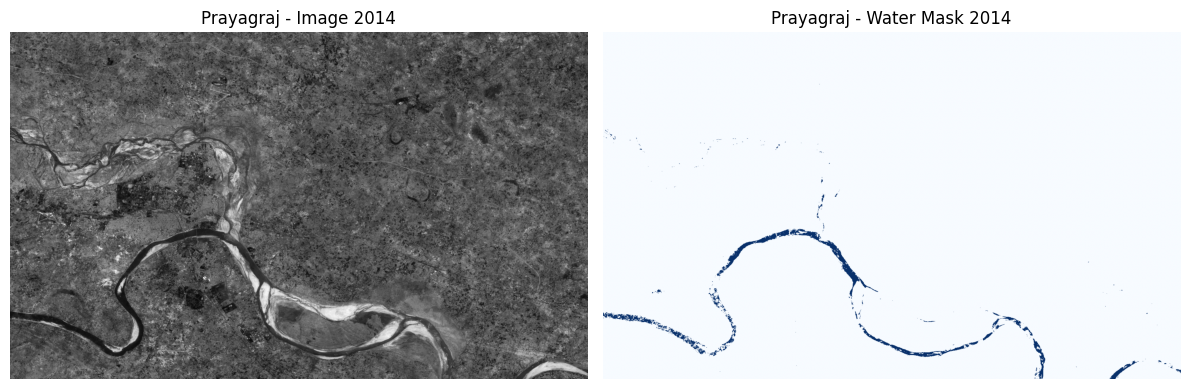

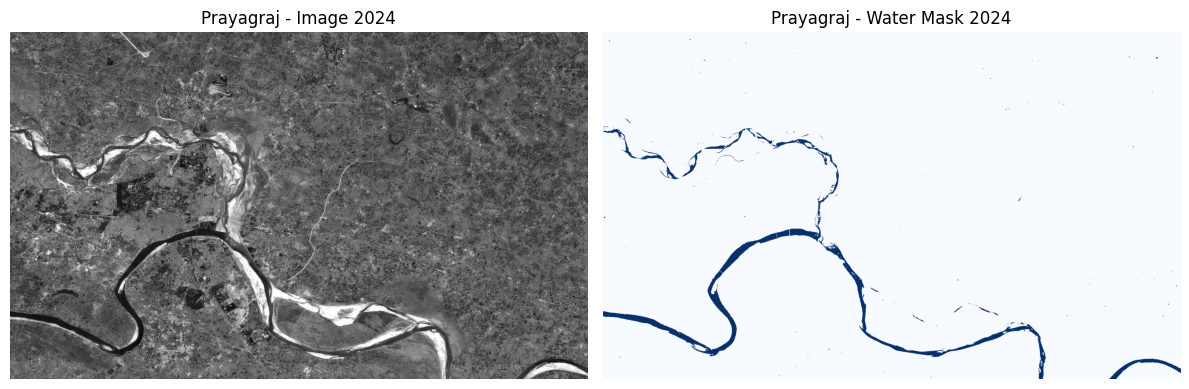

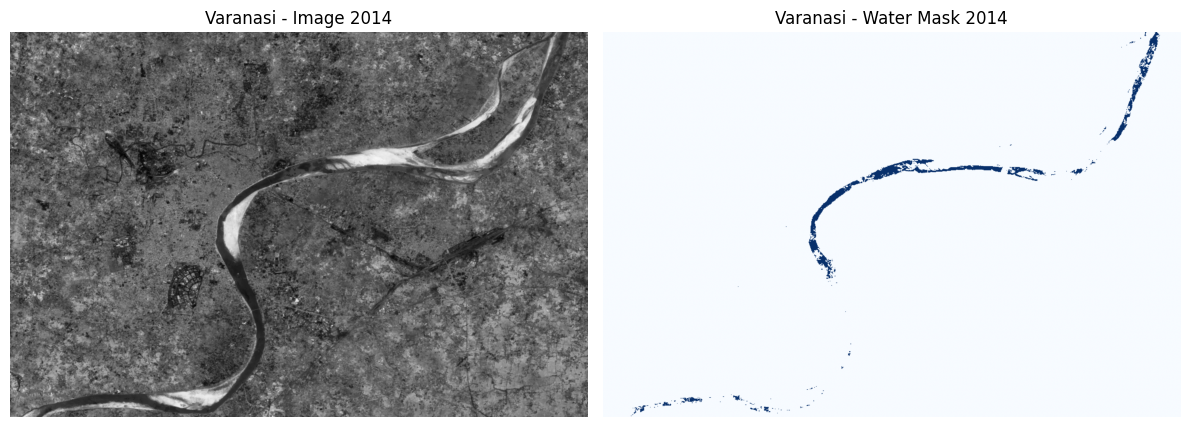

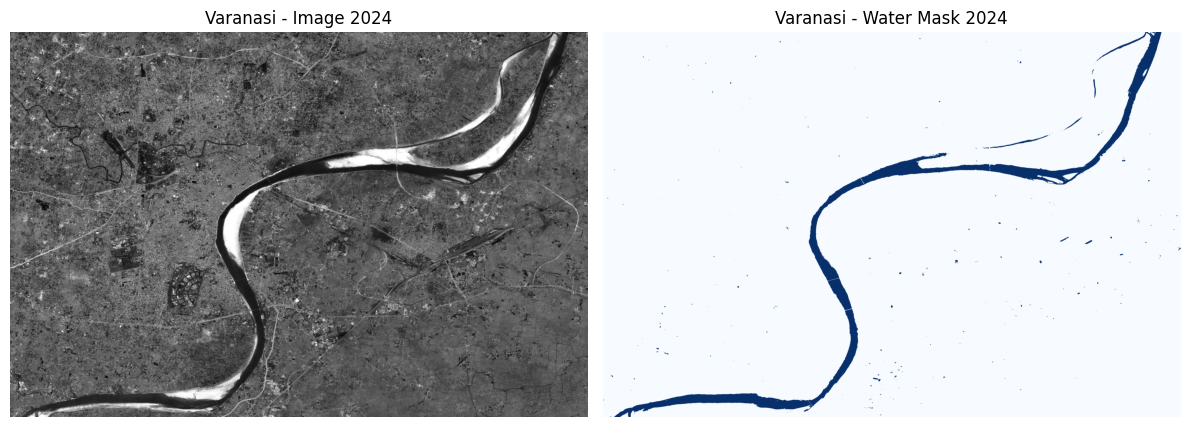

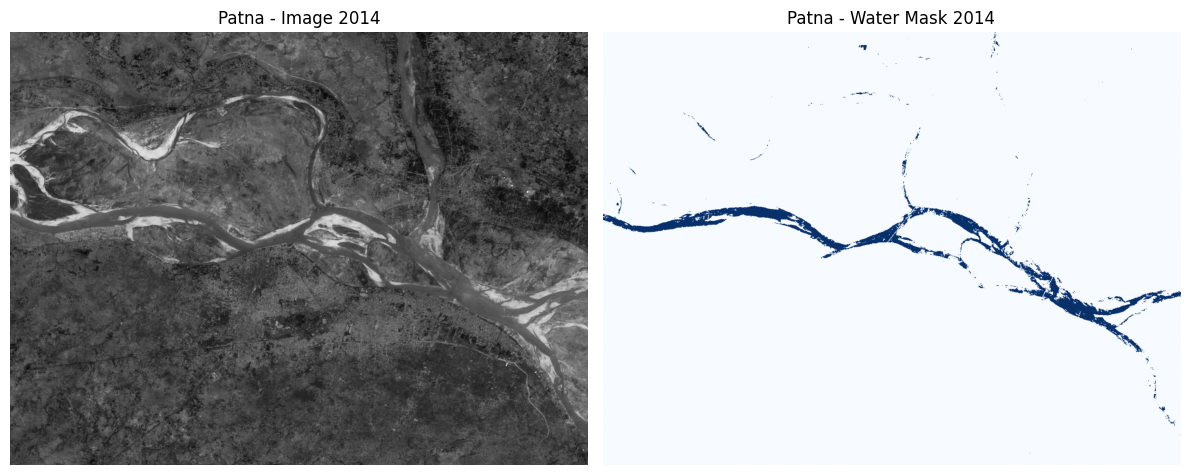

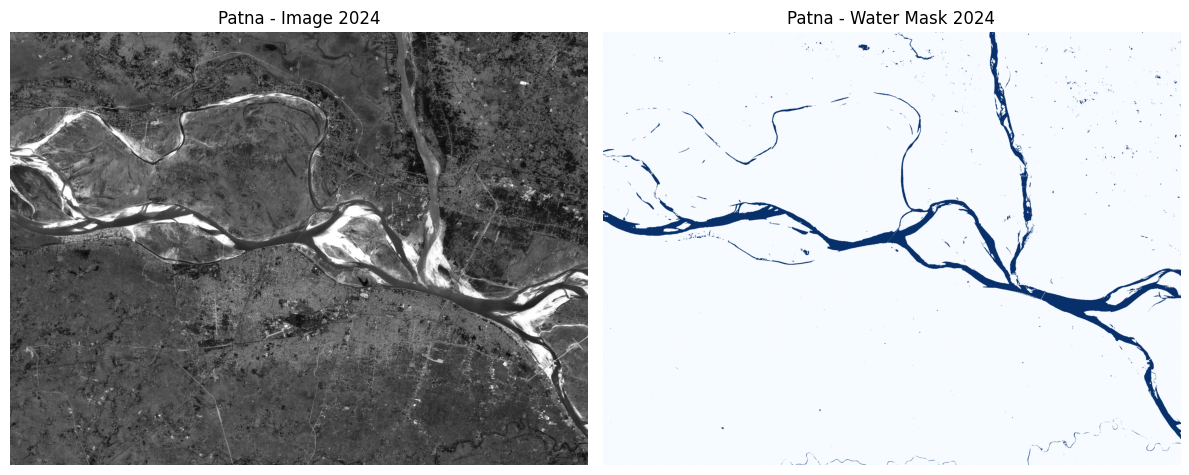

In [6]:
!pip install rasterio
import os
import matplotlib.pyplot as plt
import rasterio

# Define paths to image and mask folders in your Drive
image_dir = '/content/drive/MyDrive/imageData'
mask_dir = '/content/drive/MyDrive/maskData'

# List of cities you're working on
cities = ['Prayagraj', 'Varanasi', 'Patna']

# Loop through each city and show 2014 and 2024 images and masks
for city in cities:
    for year in ['2014', '2024']:
        img_filename = f'TrainImage_{city}_{year}.tif'
        mask_filename = f'TrainMask_{city}_{year}.tif'

        img_path = os.path.join(image_dir, img_filename)
        mask_path = os.path.join(mask_dir, mask_filename)

        # Read satellite image (just the first band for visualization)
        with rasterio.open(img_path) as src:
            image = src.read(1)

        # Read NDWI-based mask
        with rasterio.open(mask_path) as src:
            mask = src.read(1)

        # Plot
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'{city} - Image {year}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='Blues')
        plt.title(f'{city} - Water Mask {year}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import os
import rasterio
from PIL import Image

# Paths
image_dir = '/content/drive/MyDrive/imageData'
mask_dir = '/content/drive/MyDrive/maskData'

# Resize and normalize transform for images
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Resize transform for masks (kept binary)
mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Custom Dataset class
class GangaDataset(Dataset):
    def __init__(self, cities, years=['2014', '2024']):
        self.samples = []
        for city in cities:
            for year in years:
                img_path = os.path.join(image_dir, f'TrainImage_{city}_{year}.tif')
                mask_path = os.path.join(mask_dir, f'TrainMask_{city}_{year}.tif')
                self.samples.append((img_path, mask_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        with rasterio.open(img_path) as src:
            image = src.read([1, 2, 3])  # Use RGB bands
            image = np.moveaxis(image, 0, -1)  # Convert from (C, H, W) to (H, W, C)
            image = img_transform(image)

        with rasterio.open(mask_path) as src:
            mask = src.read(1)  # Grayscale mask
            mask = np.expand_dims(mask, axis=-1)  # Add channel dim
            mask = mask_transform(mask)
            mask = (mask > 0.5).float()  # Ensure binary

        return image, mask

# Create dataset and dataloader
cities = ['Prayagraj', 'Varanasi', 'Patna']
dataset = GangaDataset(cities)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Check one batch
for images, masks in dataloader:
    print("Image batch shape:", images.shape)  # (B, 3, 256, 256)
    print("Mask batch shape:", masks.shape)    # (B, 1, 256, 256)
    break


Image batch shape: torch.Size([2, 3, 256, 256])
Mask batch shape: torch.Size([2, 1, 256, 256])


In [8]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
import torch.optim as optim

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load DeepLabV3+ with a ResNet-50 backbone
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)  # Change output to 1 class
model = model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']
        outputs = outputs.squeeze(1)  # (B, H, W)

        loss = criterion(outputs, masks.squeeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.8277
Epoch [2/10], Loss: 0.8014
Epoch [3/10], Loss: 0.7696
Epoch [4/10], Loss: 0.7254
Epoch [5/10], Loss: 0.7124
Epoch [6/10], Loss: 0.6435
Epoch [7/10], Loss: 0.6006
Epoch [8/10], Loss: 0.5816
Epoch [9/10], Loss: 0.5220
Epoch [10/10], Loss: 0.5191


In [9]:
torch.save(model.state_dict(), 'ganga_deeplabv3.pth')

In [10]:
def compute_metrics(pred, target):
    pred = pred.astype(bool)
    target = target.astype(bool)

    intersection = np.logical_and(pred, target).sum()
    union = np.logical_or(pred, target).sum()
    iou = intersection / union if union > 0 else 0

    dice = 2 * intersection / (pred.sum() + target.sum()) if (pred.sum() + target.sum()) > 0 else 0

    accuracy = (pred == target).sum() / pred.size
    precision = intersection / pred.sum() if pred.sum() > 0 else 0
    recall = intersection / target.sum() if target.sum() > 0 else 0

    return {
        'IoU': iou,
        'Dice': dice,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }


In [12]:
import torch.nn.functional as F

model.eval()

for city in cities:
    print(f"\nEvaluating for {city}...")

    # Load and preprocess 2014 image
    img_2014_path = os.path.join(image_dir, f'TrainImage_{city}_2014.tif')
    with rasterio.open(img_2014_path) as src:
        img_2014 = src.read([1, 2, 3])
        img_2014 = np.moveaxis(img_2014, 0, -1)
        img_2014 = img_transform(img_2014).unsqueeze(0).to(device)

    # Predict mask for 2014
    with torch.no_grad():
        pred_2014 = model(img_2014)['out']
        pred_2014 = torch.sigmoid(pred_2014).squeeze().cpu().numpy()
        mask_pred_2014 = (pred_2014 > 0.5).astype(np.uint8)

    # Load and preprocess 2024 image
    img_2024_path = os.path.join(image_dir, f'TrainImage_{city}_2024.tif')
    with rasterio.open(img_2024_path) as src:
        img_2024 = src.read([1, 2, 3])
        img_2024 = np.moveaxis(img_2024, 0, -1)
        img_2024 = img_transform(img_2024).unsqueeze(0).to(device)

    # Predict mask for 2024
    with torch.no_grad():
        pred_2024 = model(img_2024)['out']
        pred_2024 = torch.sigmoid(pred_2024).squeeze().cpu().numpy()
        mask_pred_2024 = (pred_2024 > 0.5).astype(np.uint8)

    # Load ground truth masks
    import cv2
    gt_mask_2014_path = os.path.join(mask_dir, f'TrainMask_{city}_2014.tif')
    gt_mask_2024_path = os.path.join(mask_dir, f'TrainMask_{city}_2024.tif')

    with rasterio.open(gt_mask_2014_path) as src:
        gt_mask_2014 = src.read(1)
        gt_mask_2014 = cv2.resize(gt_mask_2014, (256, 256))
        gt_mask_2014 = (gt_mask_2014 > 0.5).astype(np.uint8)

    with rasterio.open(gt_mask_2024_path) as src:
        gt_mask_2024 = src.read(1)
        gt_mask_2024 = cv2.resize(gt_mask_2024, (256, 256))
        gt_mask_2024 = (gt_mask_2024 > 0.5).astype(np.uint8)

    # Compute metrics
    metrics_2014 = compute_metrics(mask_pred_2014, gt_mask_2014)
    metrics_2024 = compute_metrics(mask_pred_2024, gt_mask_2024)

    print("2014 -", metrics_2014)
    print("2024 -", metrics_2024)



Evaluating for Prayagraj...
2014 - {'IoU': np.float64(0.0), 'Dice': np.float64(0.0), 'Accuracy': np.float64(0.96337890625), 'Precision': np.float64(0.0), 'Recall': np.float64(0.0)}
2024 - {'IoU': np.float64(0.00028208744710860365), 'Dice': np.float64(0.0005640157924421884), 'Accuracy': np.float64(0.9459228515625), 'Precision': np.float64(0.00045599635202918376), 'Recall': np.float64(0.0007390983000739098)}

Evaluating for Varanasi...
2014 - {'IoU': np.float64(0.0), 'Dice': np.float64(0.0), 'Accuracy': np.float64(0.965057373046875), 'Precision': np.float64(0.0), 'Recall': np.float64(0.0)}
2024 - {'IoU': np.float64(0.0), 'Dice': np.float64(0.0), 'Accuracy': np.float64(0.943115234375), 'Precision': np.float64(0.0), 'Recall': np.float64(0.0)}

Evaluating for Patna...
2014 - {'IoU': np.float64(0.0), 'Dice': np.float64(0.0), 'Accuracy': np.float64(0.963226318359375), 'Precision': np.float64(0.0), 'Recall': np.float64(0.0)}
2024 - {'IoU': np.float64(0.0), 'Dice': np.float64(0.0), 'Accuracy':

In [13]:
# Metric histories
train_loss_history = []
iou_history = []
dice_history = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_dice = 0.0
    count = 0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']
        outputs = outputs.squeeze(1)

        loss = criterion(outputs, masks.squeeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Convert predictions and masks to CPU numpy arrays for metric calculation
        preds = torch.sigmoid(outputs).detach().cpu().numpy() > 0.5
        targets = masks.squeeze(1).detach().cpu().numpy()

        for i in range(preds.shape[0]):
            metrics = compute_metrics(preds[i], targets[i])
            running_iou += metrics['IoU']
            running_dice += metrics['Dice']
            count += 1

    epoch_loss = running_loss / len(dataloader)
    epoch_iou = running_iou / count
    epoch_dice = running_dice / count

    train_loss_history.append(epoch_loss)
    iou_history.append(epoch_iou)
    dice_history.append(epoch_dice)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, IoU: {epoch_iou:.4f}, Dice: {epoch_dice:.4f}")


Epoch [1/10] - Loss: 0.4802, IoU: 0.0000, Dice: 0.0000
Epoch [2/10] - Loss: 0.4687, IoU: 0.0000, Dice: 0.0000
Epoch [3/10] - Loss: 0.4588, IoU: 0.0000, Dice: 0.0000
Epoch [4/10] - Loss: 0.4354, IoU: 0.0000, Dice: 0.0000
Epoch [5/10] - Loss: 0.4229, IoU: 0.0000, Dice: 0.0000
Epoch [6/10] - Loss: 0.4179, IoU: 0.0000, Dice: 0.0000
Epoch [7/10] - Loss: 0.4152, IoU: 0.0000, Dice: 0.0000
Epoch [8/10] - Loss: 0.3989, IoU: 0.0000, Dice: 0.0000
Epoch [9/10] - Loss: 0.3879, IoU: 0.0000, Dice: 0.0000
Epoch [10/10] - Loss: 0.4014, IoU: 0.0000, Dice: 0.0000


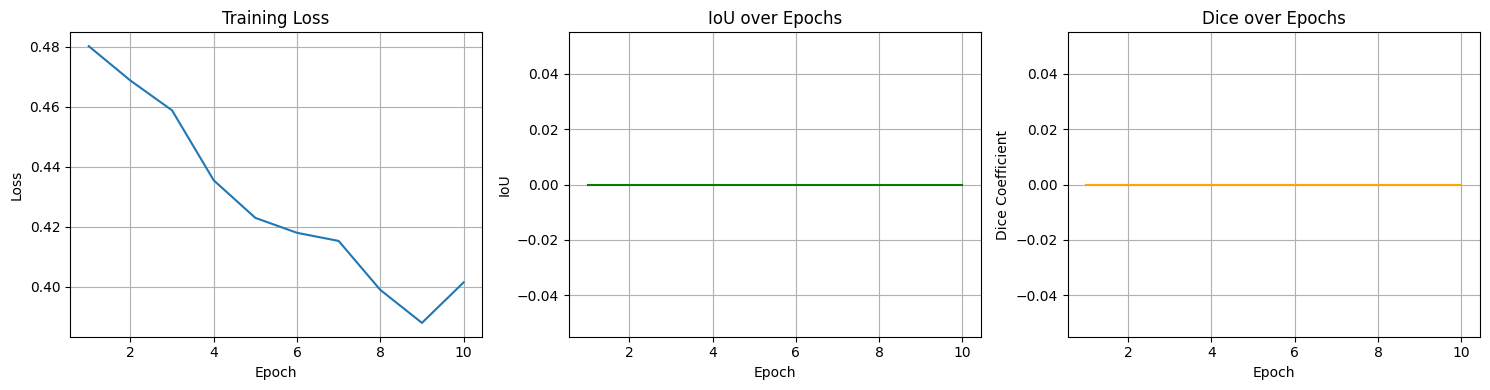

In [14]:
num_epochs = 10
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(15, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_history, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# IoU
plt.subplot(1, 3, 2)
plt.plot(epochs, iou_history, label='IoU', color='green')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU over Epochs')
plt.grid(True)

# Dice
plt.subplot(1, 3, 3)
plt.plot(epochs, dice_history, label='Dice', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Dice over Epochs')
plt.grid(True)

plt.tight_layout()
plt.show()


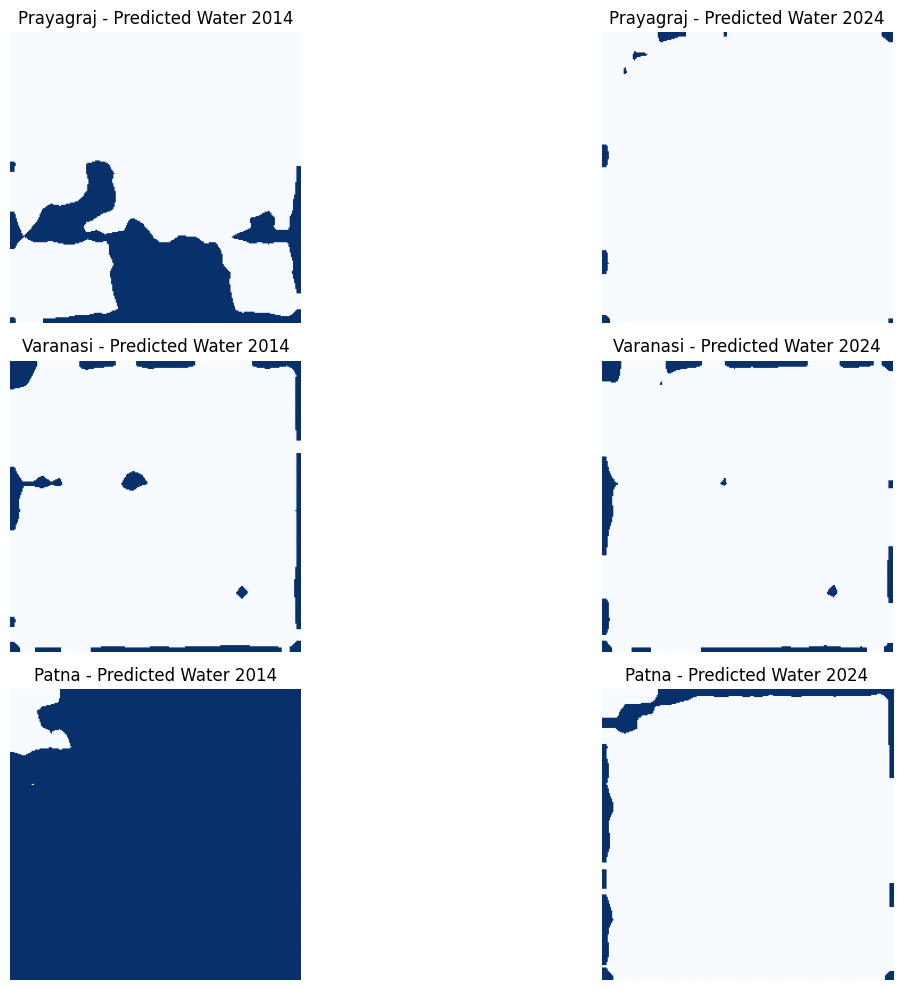

In [15]:
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import rasterio
import torch
import os

# Image transform (should match training)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))  # Same as training size
])

def predict_mask(model, image_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)  # shape: (H, W)
        image = np.stack([image] * 3, axis=-1)  # shape: (H, W, 3)

    # Transform
    image = transform(image).unsqueeze(0).to(device)  # shape: (1, 3, 256, 256)

    model.eval()
    with torch.no_grad():
        output = model(image)['out']
        pred = torch.sigmoid(output).squeeze().cpu().numpy()
        return (pred > 0.4).astype(np.uint8)  # binary mask

# List of cities to process
cities = ["Prayagraj", "Varanasi", "Patna"]

# Plotting
plt.figure(figsize=(15, 10))

for i, city in enumerate(cities, start=1):
    img_2014 = os.path.join(image_dir, f'TrainImage_{city}_2014.tif')
    img_2024 = os.path.join(image_dir, f'TrainImage_{city}_2024.tif')

    mask_pred_2014 = predict_mask(model, img_2014)
    mask_pred_2024 = predict_mask(model, img_2024)

    # Plot predictions for each city
    plt.subplot(3, 2, 2*i-1)
    plt.imshow(mask_pred_2014, cmap='Blues')
    plt.title(f"{city} - Predicted Water 2014")
    plt.axis('off')

    plt.subplot(3, 2, 2*i)
    plt.imshow(mask_pred_2024, cmap='Blues')
    plt.title(f"{city} - Predicted Water 2024")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [16]:
def overlay_mask_on_image(image_path, mask, alpha=0.5):
    with rasterio.open(image_path) as src:
        base_img = src.read(1)

    plt.imshow(base_img, cmap='gray')
    plt.imshow(mask, cmap='Blues', alpha=alpha)
    plt.axis('off')


In [17]:
from skimage.morphology import remove_small_objects

mask_pred_2014_clean = remove_small_objects(mask_pred_2014.astype(bool), min_size=500).astype(np.uint8)
mask_pred_2024_clean = remove_small_objects(mask_pred_2024.astype(bool), min_size=500).astype(np.uint8)


In [18]:
from scipy.ndimage import gaussian_filter

smoothed_2014 = gaussian_filter(mask_pred_2014_clean.astype(float), sigma=1)


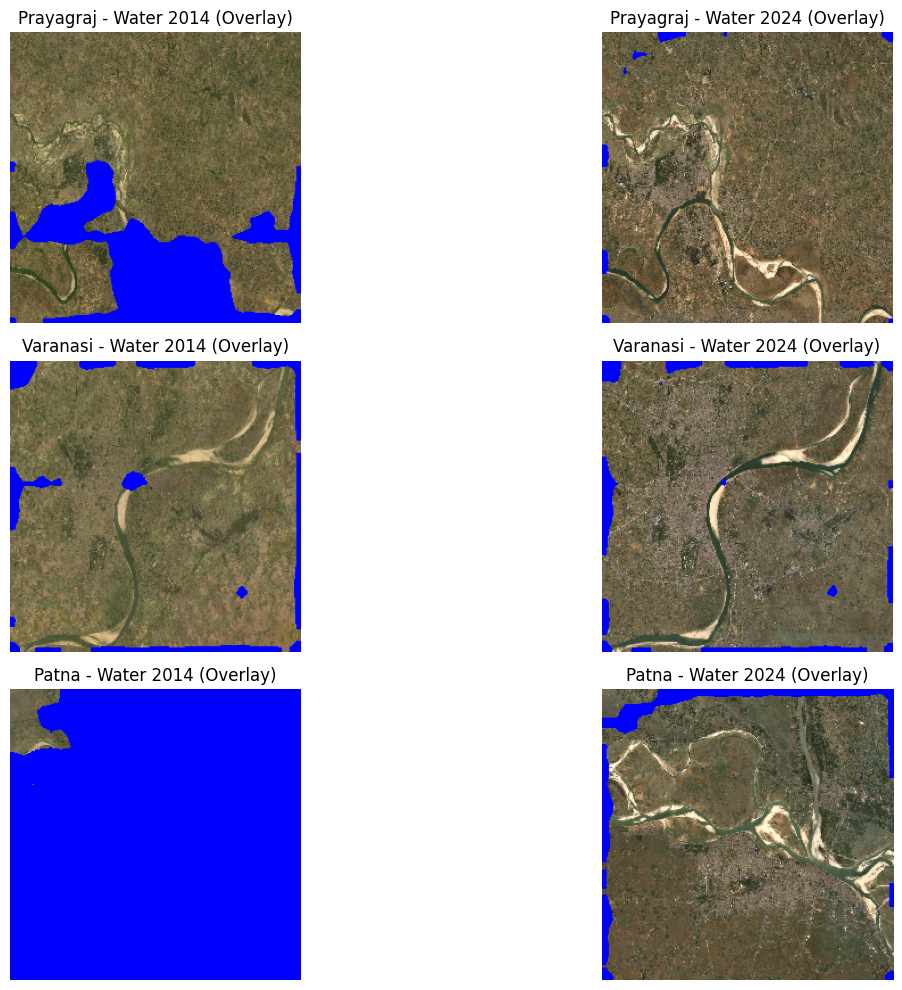

In [19]:
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import rasterio
import torch
import os
from matplotlib.colors import ListedColormap

# Image transform (should match training)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))  # Same as training size
])

def overlay_mask_on_image(image_path, mask):
    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 3])  # Read RGB channels
        image = np.moveaxis(image, 0, -1)  # Convert to (H, W, 3)

    # Resize image to match mask dimensions
    image_resized = np.array([np.array(image[:,:,i]) for i in range(3)])
    image_resized = np.stack(image_resized, axis=-1)
    image_resized = cv2.resize(image_resized, (256, 256))

    # Overlay mask on image (blending)
    overlay = image_resized * (1 - mask[..., None]) + np.array([0, 0, 255]) * mask[..., None]

    plt.imshow(overlay)
    plt.axis('off')

def predict_mask(model, image_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)  # shape: (H, W)
        image = np.stack([image] * 3, axis=-1)  # shape: (H, W, 3)

    # Transform
    image = transform(image).unsqueeze(0).to(device)  # shape: (1, 3, 256, 256)

    model.eval()
    with torch.no_grad():
        output = model(image)['out']
        pred = torch.sigmoid(output).squeeze().cpu().numpy()
        return (pred > 0.4).astype(np.uint8)  # binary mask

# List of cities to process
cities = ["Prayagraj", "Varanasi", "Patna"]

# Plotting
plt.figure(figsize=(15, 10))

for i, city in enumerate(cities, start=1):
    img_2014 = os.path.join(image_dir, f'TrainImage_{city}_2014.tif')
    img_2024 = os.path.join(image_dir, f'TrainImage_{city}_2024.tif')

    mask_pred_2014 = predict_mask(model, img_2014)
    mask_pred_2024 = predict_mask(model, img_2024)

    # Plotting overlay for each city
    plt.subplot(3, 2, 2*i-1)
    overlay_mask_on_image(img_2014, mask_pred_2014)
    plt.title(f"{city} - Water 2014 (Overlay)")

    plt.subplot(3, 2, 2*i)
    overlay_mask_on_image(img_2024, mask_pred_2024)
    plt.title(f"{city} - Water 2024 (Overlay)")

plt.tight_layout()
plt.show()


In [20]:
area_2014 = np.sum(mask_pred_2014)
area_2024 = np.sum(mask_pred_2024)

print(f"{city} Water Area 2014: {area_2014} pixels")
print(f"{city} Water Area 2024: {area_2024} pixels")
print(f"Shrinkage: {area_2014 - area_2024} pixels ({(area_2014 - area_2024) / area_2014 * 100:.2f}%)")


Patna Water Area 2014: 63401 pixels
Patna Water Area 2024: 4039 pixels
Shrinkage: 59362 pixels (93.63%)


Prayagraj Water Area 2014: 13634 pixels
Prayagraj Water Area 2024: 565 pixels
Shrinkage: 13069 pixels (95.86%)
Varanasi Water Area 2014: 4296 pixels
Varanasi Water Area 2024: 3181 pixels
Shrinkage: 1115 pixels (25.95%)
Patna Water Area 2014: 63401 pixels
Patna Water Area 2024: 4039 pixels
Shrinkage: 59362 pixels (93.63%)


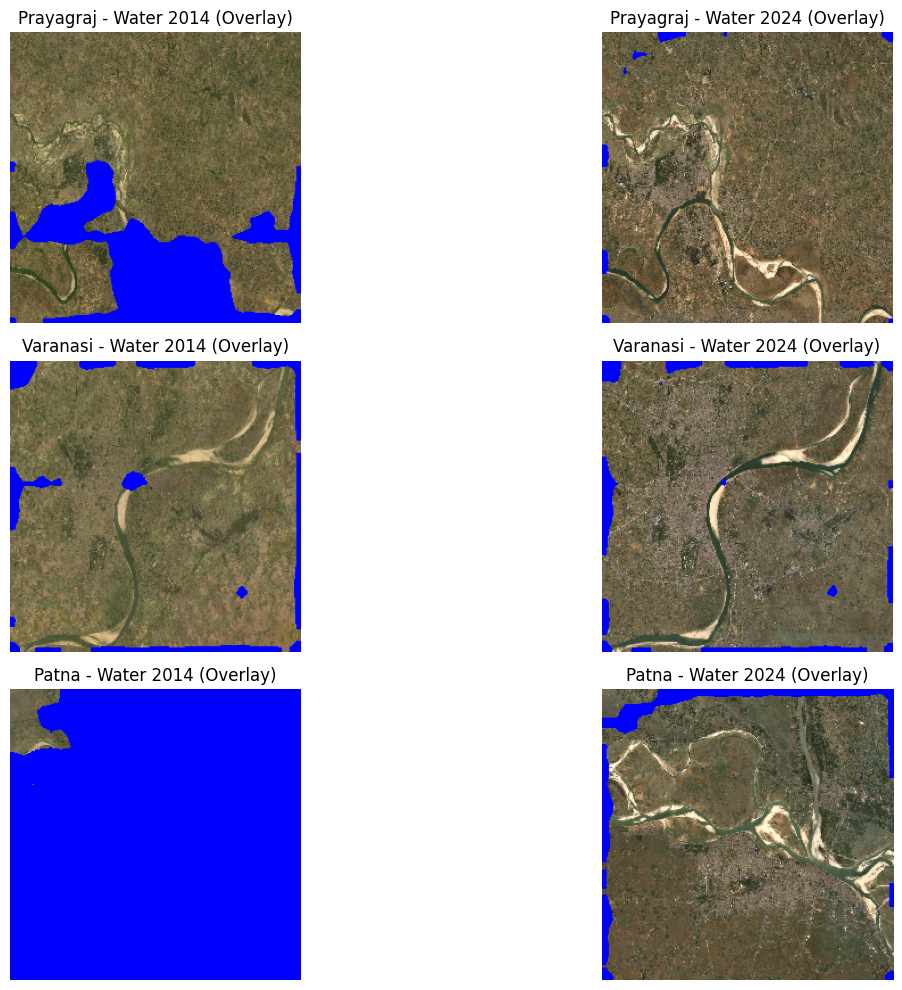

In [21]:
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import rasterio
import torch
import os
import cv2

# Image transform (should match training)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))  # Same as training size
])

def overlay_mask_on_image(image_path, mask):
    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 3])  # Read RGB channels
        image = np.moveaxis(image, 0, -1)  # Convert to (H, W, 3)

    # Resize image to match mask dimensions
    image_resized = np.array([np.array(image[:,:,i]) for i in range(3)])
    image_resized = np.stack(image_resized, axis=-1)
    image_resized = cv2.resize(image_resized, (256, 256))

    # Overlay mask on image (blending)
    overlay = image_resized * (1 - mask[..., None]) + np.array([0, 0, 255]) * mask[..., None]

    plt.imshow(overlay)
    plt.axis('off')

def predict_mask(model, image_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)  # shape: (H, W)
        image = np.stack([image] * 3, axis=-1)  # shape: (H, W, 3)

    # Transform
    image = transform(image).unsqueeze(0).to(device)  # shape: (1, 3, 256, 256)

    model.eval()
    with torch.no_grad():
        output = model(image)['out']
        pred = torch.sigmoid(output).squeeze().cpu().numpy()
        return (pred > 0.4).astype(np.uint8)  # binary mask

# List of cities to process
cities = ["Prayagraj", "Varanasi", "Patna"]

# Plotting and calculating areas
plt.figure(figsize=(15, 10))

for i, city in enumerate(cities, start=1):
    img_2014 = os.path.join(image_dir, f'TrainImage_{city}_2014.tif')
    img_2024 = os.path.join(image_dir, f'TrainImage_{city}_2024.tif')

    mask_pred_2014 = predict_mask(model, img_2014)
    mask_pred_2024 = predict_mask(model, img_2024)

    # Plotting overlay for each city
    plt.subplot(3, 2, 2*i-1)
    overlay_mask_on_image(img_2014, mask_pred_2014)
    plt.title(f"{city} - Water 2014 (Overlay)")

    plt.subplot(3, 2, 2*i)
    overlay_mask_on_image(img_2024, mask_pred_2024)
    plt.title(f"{city} - Water 2024 (Overlay)")

    # Area calculation
    area_2014 = np.sum(mask_pred_2014)
    area_2024 = np.sum(mask_pred_2024)

    print(f"{city} Water Area 2014: {area_2014} pixels")
    print(f"{city} Water Area 2024: {area_2024} pixels")
    print(f"Shrinkage: {area_2014 - area_2024} pixels ({(area_2014 - area_2024) / area_2014 * 100:.2f}%)")

plt.tight_layout()
plt.show()


In [23]:
pixel_size = 30 * 30  # for Landsat, in m²
shrinkage_pixels = np.logical_and(mask_pred_2014_clean == 1, mask_pred_2024_clean == 0).sum()
shrinkage_area_km2 = (shrinkage_pixels * pixel_size) / 1e6
print(f"{city} - Water area lost: {shrinkage_area_km2:.2f} km²")


Patna - Water area lost: 54.46 km²
